# Энкодер-декодер архитектура
Сегодня мы рассмотрим такую важную архитектуру как энкодер-декодер.
В контексте обработки естественного языка эта архитекутра используется чаще всего в задачах преобразования последовательности в последовательность (seq2seq). Такие задачи включают, например, машинный перевод. 

Вопрос: Что еще бывает?

Рассмотрим общий вид таких моделей (здесь и далее иллюстрации из курса Лены Войты): 

![alt_text](../additional_materials/images/enc_dec-min.png)

Мы с вами до сих пор занимались рекуррентными сетями. Мы уже знаем, как модель работает в случае обычного моделирования языка. В случае энкодер-декодера в ней принципиально ничего не меняется - мы все еще будем генерировать предложения токен за токеном. Однако для формирования результата нам нужно уже что-то, описывающее вход. Энкодер-декодер в случае перевода имеет вид что=то вроде следующего:

![alt_text](../additional_materials/images/enc_dec_simple_rnn-min.png)

Идея довольно проста - давайте использовать последнее скрытое состояние закодированного входа как начальное для выхода. 
Вопрос: в чем минус такого решения?
Вопрос: а если у нас на входе не текст?


Мы опробуем наши модели кодировщика-декодера на проблеме понимания изображений. Эта задача, с одной стороны, заставляет нас использовать соответствующую архитектуру, с другой - позволяет опустить обучение энкодера, сосредоточившись только на декодере. 

Прежде чем мы перейдем к архитектуре, необходимо выполнить предварительную обработку. У нас есть две части нашей задачи - изображения и их описания. Для текстов нам необходимо применить токенизацию.

Однако, в отличие от прошлого раза, мы не будем применять простейшее представление текста. Наши строки данных содержат уникальные редкие слова. Если мы будем действовать на уровне слова, нам придется иметь дело с большим словарным запасом, мучаться с нормализацией и т.д. Если вместо этого использовать модели на уровне символов, то для обработки последовательности потребуется много итераций. На этот раз мы выберем что-нибудь среднее.

Один из популярных подходов называется кодированием Byte Pair (BPE). Алгоритм начинается с токенизации на уровне символов, а затем итеративно объединяет наиболее часто встречающиеся пары в течении N итераций. Это приводит к тому, что часто встречающиеся слова объединяются в один символ, а редкие слова разбиваются на слоги или даже символы. С одной стороны, мы отнсительно эффективно составляем словарб, с другой стороны, если мы даже не будем знать новое слово, мы сможем побить его на символы и все равно закодировать.

Установим необходиме библиотеки:

In [1]:
from torchmetrics.text import BLEUScore

from homeworks.wandb_hw2 import train
!pip install nltk

In [2]:
!pip install subword_nmt

In [776]:
from os.path import join as pjoin
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
import os
import pandas as pd
from PIL import Image
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter

from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights


In [777]:
data_path = r"C:\Users\tosha\PycharmProjects\spbu_deep_learning\notebooks\data\flikr"

Протокенизируем наш датасет. Здесь мы возьмем все текстовые строки из корпуса и составим токены для них. 
Вопрос: а как нам пришлось бы токенизировать тексты в случае машинного перевода?

In [877]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train', 'w') as f_src:
    for line in open(pjoin(data_path, 'captions.txt')):
        words = line.strip().split(',')
        image, src_line = words[0], ",".join(words[1:])
        f_src.write(tokenize(src_line) + '\n')

# build and apply bpe voc
learn_bpe(open('./train', 'r'), open('bpe_rules', 'w'), num_symbols=8000)
bpe = BPE(open('./bpe_rules', 'r'))
    
with open('train.bpe', 'w') as f_out:
    for line in open('train'):
        f_out.write(bpe.process_line(line.lower().strip()) + '\n')

100%|██████████| 8000/8000 [00:04<00:00, 1668.57it/s]


Теперь нам нужно создать словарь, который сопоставляет строки с токенами и наоборот.Это нам понадобится, когда мы захотим тренировать модель.

In [878]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [879]:
data_inp = np.array(open('./train.bpe').read().split('\n'))
from vocab import Vocab
voc = Vocab.from_lines(data_inp)

Наш токенизатор и словарь умеют переводить сразу несколько строк в матрицу токенов, давая результирующий тензор максимальной или заданной длины. Проверим, что все нормально.

In [880]:
from torchmetrics.text import BLEUScore


def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss = 0.0
    model.train()
    for batch in tqdm(train_loader, desc=tqdm_desc):
        embeds = batch['x'].to(device)
        tokens = batch['y'].to(device)
        logits = model(tokens, embeds)
        loss = criterion(logits[:, :-1, :].swapaxes(1, 2), tokens[:, 1:])
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * embeds.shape[0]

    train_loss /= len(train_loader.dataset)
    return train_loss


@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, tqdm_desc):
    valid_loss = 0.0
    model.eval()
    for batch in tqdm(valid_loader, desc=tqdm_desc):
        embeds = batch['x'].to(device)
        tokens = batch['y'].to(device)
        logits = model(tokens, embeds)
        loss = criterion(logits[:, :-1, :].swapaxes(1, 2), tokens[:, 1:].to(device))
        valid_loss += loss.item() * embeds.shape[0]

    valid_loss /= len(valid_loader.dataset)
    return valid_loss


def evaluate_bleu(model, valid_loader):
    bleu_score = 0.0
    # bleu = BLEUScore()
    # for batch in valid_loader:
    #     embeds = batch['x']
    #     tokens_true = batch['y']
    #     tokens_pred = model.inference(embeds)
    #     
    #     lines = voc.to_lines(tokens_pred)
    #     true_lines = voc.to_lines(tokens_true)
    #     bleu_score += bleu(lines, true_lines).item() * embeds.shape[0]
    # bleu_score /= len(valid_loader.dataset)
    return bleu_score


def train(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs, log_frequency=1):
    train_losses, valid_losses, valid_blues = [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        valid_loss = validation_epoch(
            model, criterion, valid_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if epoch % log_frequency == 0:
            valid_bleu = evaluate_bleu(model, valid_loader)
            valid_blues += [valid_bleu]

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        valid_losses += [valid_loss]
        plot_losses(train_losses, valid_losses, valid_blues)

In [881]:
# Here's how you cast lines into ids and backwards.
batch_lines = sorted(data_inp, key=len)[5:10]
batch_ids = voc.to_matrix(batch_lines)
batch_lines_restored = voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['a cyclist', 'cap@@ tion', 'dog in air', 'a dog runs', 'a group of']

words to ids (0 = bos, 1 = eos):
tensor([[   0,   50, 1376,    1,    1],
        [   0,  854, 6222,    1,    1],
        [   0, 1549, 2862,  132,    1],
        [   0,   50, 1549, 4962,    1],
        [   0,   50, 2492, 3900,    1]])

back to words
['a cyclist', 'cap@@ tion', 'dog in air', 'a dog runs', 'a group of']


Также мы можем узнать, какое распределение числа токенов на предложение

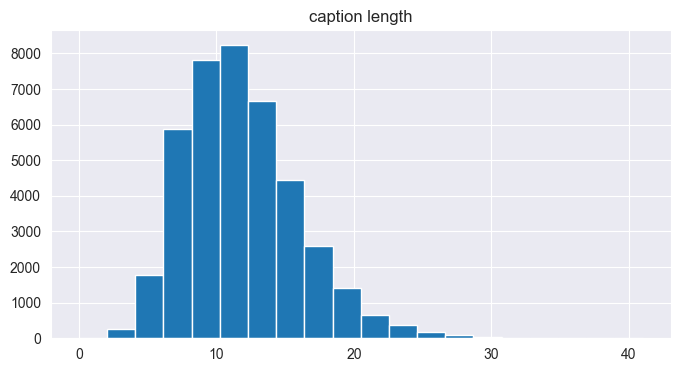

In [882]:
plt.figure(figsize=(8, 4))
plt.title("caption length")
plt.hist(list(map(len, map(str.split, data_inp))), bins=20)
plt.show()

Как выглядит наш датасет? 

In [818]:
captions = pd.read_csv(pjoin(data_path, 'captions.txt')).dropna()
captions

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles .
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [819]:
captions['caption'] = captions['caption'].apply(str.lower)

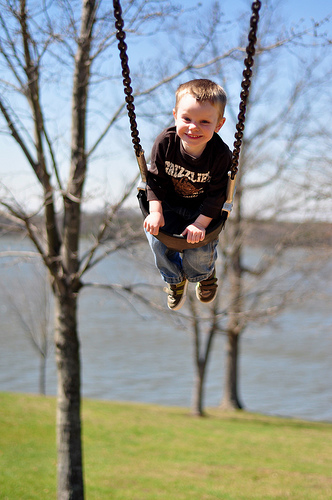

In [820]:
image_file = captions["image"].sample(1).iloc[0]
# выведите все описания для этой картинки
Image.open(pjoin(data_path, "Images", image_file))

In [821]:
captions[captions['image'] == image_file]

,image,caption
27055,3396036947_0af6c3aab7.jpg,a boy on a swing .
27056,3396036947_0af6c3aab7.jpg,a little boy is swinging on a swing beside some trees and a river .
27057,3396036947_0af6c3aab7.jpg,a toddler swings back very high .
27058,3396036947_0af6c3aab7.jpg,a young boy is riding a swing high in the air .
27059,3396036947_0af6c3aab7.jpg,small child swinging on a swing with trees in the background .


In [822]:
image_ids = {k: i for i, k in enumerate(captions["image"].unique())}
image_list = list(map(lambda x: x[0], sorted(image_ids.items(), key=lambda x: x[1])))
captions['image_id'] = captions["image"].map(image_ids)

In [823]:
class ImagesDataset(Dataset):
    def __init__(self, root, image_list, transform=None):
        super().__init__()
        self.root = root
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, item):
        image = Image.open(pjoin(self.root, image_list[item]))
        if self.transform:
            image = self.transform(image)
        return image
        

In [824]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [294]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch import nn
cnn_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1).eval().to(device)
cnn_model.classifier = nn.Identity()

In [319]:
import torchvision.transforms as T

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

dataset = ImagesDataset(root=pjoin(data_path, "Images"), image_list=image_list, transform=transform)
dataloader = DataLoader(dataset, shuffle=False, batch_size=4)

In [320]:
dataset[0].shape

torch.Size([3, 224, 224])

In [321]:
image_embeds = []

with torch.no_grad():
    for images in tqdm(dataloader):
        embeds = cnn_model(images.to(device))
        image_embeds += [embeds.cpu()]

image_embeds = torch.cat(image_embeds, dim=0)

  0%|          | 0/2023 [00:00<?, ?it/s]

Протестируем результат

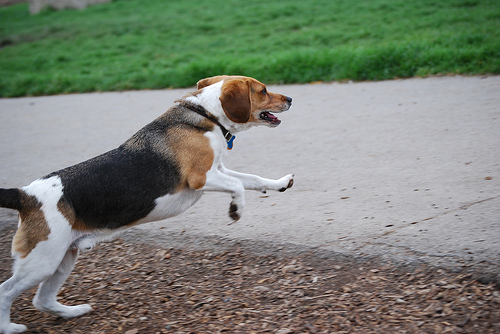

In [825]:
i = 1001
image = Image.open(pjoin(data_path, "Images", image_list[i])).convert('RGB')
image

In [826]:
cnn_model(transform(image).to(device).unsqueeze(0))

tensor([[0.4467, 0.2166, 1.0118,  ..., 0.8562, 0.0614, 0.7757]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [827]:
image_embeds[i]

tensor([0.4458, 0.2169, 1.0124,  ..., 0.8587, 0.0610, 0.7772])

In [828]:
captions[captions.image_id == 1001]

,image,caption,image_id
5005,2099323664_bb20457f26.jpg,a dog jumps onto the sidewalk .,1001
5006,2099323664_bb20457f26.jpg,a small dog runs from the dirt onto the street,1001
5007,2099323664_bb20457f26.jpg,"a tan , white , and black dog runs towards a sidewalk .",1001
5008,2099323664_bb20457f26.jpg,dog leaps out .,1001
5009,2099323664_bb20457f26.jpg,the brown and white dog is standing on its hind legs beside the path .,1001


Итак, у нас все готово для создания тренировочного датасета: вхожные изображения, эмбеддинги и описания. При этом несколько описаний могут использоваться для одного изображения, поэтому будем делить датасет именно по описаниям.

In [829]:
captions['image_id'] = captions['image_id'].astype(int)

In [830]:
captions.iloc[5005]

image             2099323664_bb20457f26.jpg
caption     a dog jumps onto the sidewalk .
image_id                               1001
Name: 5005, dtype: object

In [831]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_embeds, test_embeds, train_captions, test_captions  = train_test_split(
    [captions.iloc[i]['image'] for i in range(len(captions))],
    [image_embeds[captions.iloc[i]['image_id']].reshape(-1).contiguous() for i in range(len(captions))],
    [captions.iloc[i]['caption'] for i in range(len(captions))],
    test_size=0.2
)

In [832]:
train_embeds = torch.stack(train_embeds, dim=0)
test_embeds = torch.stack(test_embeds, dim=0)
train_embeds.shape, test_embeds.shape

(torch.Size([32364, 1280]), torch.Size([8091, 1280]))

In [883]:
class CaptionsDataset(Dataset):
    def __init__(self, captions, embeds, images, max_len=64):
        super().__init__()
        self.captions = captions
        self.images = images
        self.embeds = embeds

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, item):
        return { "x": self.embeds[item], "y": self.captions[item]}

В этот раз мы попробуем написать свою кастомную функцию склейки в батч с использованием словаря. Она берет элементы батча (список словарей)) и должна объединить x и y в тензоры

In [884]:
def rnn_collate_fn(batch):
    # your code 
    return {
        "x": torch.stack([sample['x'] for sample in batch]),
        "y": voc.to_matrix([sample['y'] for sample in batch])
    }

Теперь ее достаточно передать в даталоадер при инициализации

In [885]:
train_set = CaptionsDataset(train_captions, train_embeds, train_images)
test_set = CaptionsDataset(test_captions, test_embeds, test_images)

In [886]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, collate_fn=rnn_collate_fn)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, collate_fn=rnn_collate_fn)
embeds_loader = DataLoader(test_embeds, batch_size=128, shuffle=False)

In [887]:
for batch in train_loader:
    break

In [888]:
batch

{'x': tensor([[2.1082e+00, 8.6689e-01, 2.3513e-04,  ..., 0.0000e+00, 8.6750e-01,
          5.1550e-01],
         [6.3592e-01, 5.4783e-02, 1.2784e-01,  ..., 2.3159e-01, 7.5875e-01,
          7.2417e-01],
         [5.0617e-01, 2.9751e-01, 4.9805e-01,  ..., 2.0882e-01, 1.8990e+00,
          1.2986e-02],
         ...,
         [1.4756e+00, 1.0851e-01, 2.5226e-03,  ..., 8.6160e-02, 4.4889e-01,
          6.0367e-02],
         [1.5124e+00, 1.4354e-01, 6.4161e-03,  ..., 2.2283e-01, 3.4066e-01,
          2.1338e-01],
         [6.8049e-01, 6.1678e-01, 1.6036e+00,  ..., 1.4147e+00, 1.0044e+00,
          3.3340e-01]]),
 'y': tensor([[   0, 2492, 3900,  ...,    1,    1,    1],
         [   0,   50, 6866,  ...,    1,    1,    1],
         [   0,   50, 1008,  ...,    1,    1,    1],
         ...,
         [   0, 1008, 2862,  ...,    1,    1,    1],
         [   0, 3344,  693,  ...,    1,    1,    1],
         [   0,   50,  581,  ...,    1,    1,    1]])}

Теперь займемся моделью. Она должна содержать как энкодер, так и декодер. Энкодер должен преобразовывать входной эмбеддинг в понятное модели начальное состояние (скрытое представление и вход), а декодер должен, начиная с этого состояния, генерировать последовательность. Обратите внимание, что если слоев у LSTM больше одного, то инициализировать мы должны все слои сразу. 

Здесь мы также использоуем слой эмбеддинга, который позволит нам перевести токены в векторы.


In [889]:
len(voc.tokens)

6995

In [890]:
class CaptionRNN(nn.Module):
    def __init__(self, image_embed_dim, vocab_size, pad_index=1, eos_index=-1, embed_dim=256, hidden_dim=256, lstm_layers=3, dropout=0.1):
        super().__init__()
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim

        self.image_embed_to_h0 = nn.Linear(image_embed_dim, hidden_dim)
        self.image_embed_to_c0 = nn.Linear(image_embed_dim, hidden_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, lstm_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.eos_index = eos_index
        self.pad_index = pad_index 

    def forward(self, tokens, image_embeds):
        '''
        B - batch size
        M - lstm layers
        L - sequence length
        I - image embedding dim
        E - embedding dim
        H - hidden dim
        V - vocab size
        '''
        # image_embeds: (B, I)
        # c0 = # your code
        # h0, co: (M, B, H)
        # tokens: (B, L)
        # embeds: (B, L, E)
        # output: (B, L, H), (h, c): (M, B, H)
        # logits: (B, L, V)
        image_embeds = image_embeds
        tokens = tokens
        h0 = self.image_embed_to_h0(image_embeds).unsqueeze(0).repeat(self.lstm_layers, 1, 1)
        c0 = self.image_embed_to_c0(image_embeds).unsqueeze(0).repeat(self.lstm_layers, 1, 1)
        x = self.embedding(tokens)
        x, (h, c) = self.lstm(x, (h0, c0))
        logits = self.linear(x)
        return logits

    @torch.no_grad()
    def inference(self, image_embeds):
        self.eval()
        # generate lstm input
        B = image_embeds.shape[0]
        h = self.image_embed_to_h0(image_embeds).unsqueeze(0).repeat(self.lstm_layers, 1, 1)
        c = self.image_embed_to_c0(image_embeds).unsqueeze(0).repeat(self.lstm_layers, 1, 1)
        # init tokens with <bos>
        tokens = torch.zeros((B, 1), dtype=torch.long, device=device)
        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < 64:
            if ((tokens == self.eos_index).sum(1) > 0).all():
                break
            x = self.embedding(tokens)
            x, (h, c) = self.lstm(x, (h, c))
            logits = self.linear(x)[:, -1, :]
            # process newly obtained token
            # your code
            # get new tokens from logits
            new_tokens = logits.argmax(dim=-1).unsqueeze(1)
            tokens = torch.cat([tokens, new_tokens], dim=1)

        return tokens

In [891]:
model = CaptionRNN(image_embeds.shape[1], vocab_size=len(voc), eos_index=voc.eos_ix, pad_index=voc.unk_ix).to(device)

for batch in train_loader:
    break  

In [892]:
batch

{'x': tensor([[0.8494, 0.7772, 0.1829,  ..., 0.6844, 0.3087, 0.3259],
         [1.3713, 0.4151, 0.2291,  ..., 0.8862, 0.2596, 0.7529],
         [0.2356, 0.3846, 0.2548,  ..., 1.7194, 0.0577, 0.2548],
         ...,
         [1.5760, 0.4240, 1.1246,  ..., 1.4428, 0.3870, 0.3061],
         [0.4058, 0.1999, 1.0974,  ..., 0.4072, 1.7218, 0.0170],
         [1.7234, 1.6554, 0.0244,  ..., 0.4867, 1.1990, 0.5217]]),
 'y': tensor([[   0, 3933,  693,  ..., 6703,   16,    1],
         [   0,  581,  182,  ...,    1,    1,    1],
         [   0,   50, 3456,  ...,    1,    1,    1],
         ...,
         [   0,   50, 6087,  ...,    1,    1,    1],
         [   0,   50, 3456,  ...,    1,    1,    1],
         [   0,   50, 6098,  ...,    1,    1,    1]])}

In [893]:
# testing

logits = model(batch["y"].to(device), batch["x"].to(device))

tokenss = model.inference(embeds.to(device))
voc.to_lines(tokenss)

['flags tively tively tively tively tively tively tively tively tively tively tively tively tively tively ctions ctions ctions ctions fist fist fist fist thered thered thered spec@@ spec@@ spec@@ spec@@ spec@@ pearls pearls pearls spec@@ spec@@ fist spec@@ spec@@ pearls fist spec@@ spec@@ spec@@ pearls fist spec@@ spec@@ spec@@ pearls fist spec@@ spec@@ spec@@ pearls fist spec@@ spec@@ spec@@ pearls fist spec@@ spec@@',
 'drivers ornate tively tively tively tively tively tively tively tively tively tively tively ctions ctions ctions ctions fist fist fist fist thered thered thered spec@@ spec@@ spec@@ spec@@ spec@@ pearls pearls pearls spec@@ spec@@ fist spec@@ spec@@ pearls fist spec@@ spec@@ spec@@ pearls fist spec@@ spec@@ spec@@ pearls fist spec@@ spec@@ spec@@ pearls fist spec@@ spec@@ spec@@ pearls fist spec@@ spec@@ spec@@ pearls',
 'coal tively tively ctions ctions ctions ctions fist fist fist thered thered thered spec@@ spec@@ spec@@ spec@@ spec@@ pearls pearls pearls spec@@ sp

In [894]:
logits.shape

torch.Size([128, 28, 6995])

In [895]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
import numpy as np


BLEU_FREQ = 5


def plot_losses(train_losses, test_losses, test_blues):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train', color='deepskyblue', linewidth=2)
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test', color='springgreen', linewidth=2)
    axs[0].set_ylabel('loss')

    axs[1].plot(BLEU_FREQ * np.arange(1, len(test_blues) + 1), test_blues, label='test',
                color='springgreen', linewidth=2)
    axs[1].set_ylabel('BLEU')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

Напишем трейн луп. Он похож на то, что мы делали раньше, однако мы не используем пакинг. Допольнительное задание: напишите лосс функцию для нашей задачи вручную.

Для оценки модели мы попробуем использовать BLEU.Эта метрика была создана для машинного перевода, но может использоваться и длядругих приложений. Эта метрика просто вычисляет, какая часть предсказанных n-грамм действительно присутствует в эталонном переводе. Он делает это для n=1,2,3 и 4 и вычисляет среднее геометрическое со штрафом, если перевод короче эталонного.

Хотя BLEU имеет множество недостатков, он по-прежнему остается наиболее часто используемой метрикой и одной из самых простых для расчета.

In [896]:
from torchmetrics.text import BLEUScore


def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss = 0.0
    model.train()
    for batch in tqdm(train_loader, desc=tqdm_desc):
        embeds = batch['x'].to(device)
        tokens = batch['y'].to(device)
        logits = model(tokens, embeds)
        loss = criterion(logits[:, :-1, :].swapaxes(1, 2), tokens[:, 1:])
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * embeds.shape[0]

    train_loss /= len(train_loader.dataset)
    return train_loss


@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, tqdm_desc):
    valid_loss = 0.0
    model.eval()
    for batch in tqdm(valid_loader, desc=tqdm_desc):
        embeds = batch['x'].to(device)
        tokens = batch['y'].to(device)
        logits = model(tokens, embeds)
        loss = criterion(logits[:, :-1, :].swapaxes(1, 2), tokens[:, 1:].to(device))
        valid_loss += loss.item() * embeds.shape[0]

    valid_loss /= len(valid_loader.dataset)
    return valid_loss


def evaluate_bleu(model, valid_loader):
    bleu_score = 0.0
    # bleu = BLEUScore()
    # for batch in valid_loader:
    #     embeds = batch['x']
    #     tokens_true = batch['y']
    #     tokens_pred = model.inference(embeds)
    #     
    #     lines = voc.to_lines(tokens_pred)
    #     true_lines = voc.to_lines(tokens_true)
    #     bleu_score += bleu(lines, true_lines).item() * embeds.shape[0]
    # bleu_score /= len(valid_loader.dataset)
    return bleu_score


def train(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs, log_frequency=1):
    train_losses, valid_losses, valid_blues = [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        valid_loss = validation_epoch(
            model, criterion, valid_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if epoch % log_frequency == 0:
            valid_bleu = evaluate_bleu(model, valid_loader)
            valid_blues += [valid_bleu]

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        valid_losses += [valid_loss]
        plot_losses(train_losses, valid_losses, valid_blues)

In [897]:
NUM_EPOCHS = 200

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = None
criterion = nn.CrossEntropyLoss(ignore_index=1)

sum(param.numel() for param in model.parameters())

5823315

In [898]:
for name, param in model.named_parameters():
    print(name, torch.abs(param.grad).mean())

TypeError: abs(): argument 'input' (position 1) must be Tensor, not NoneType

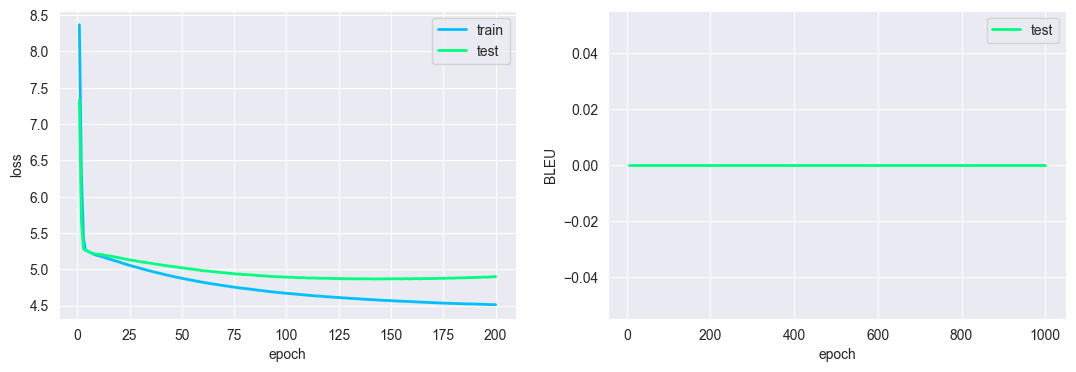

In [899]:
train(model, optimizer, scheduler, criterion, train_loader, test_loader, 200)

Также посмотрим на случайную картинку из нашего набора.

In [900]:
def caption_random_test_image():
    index = np.random.randint(len(test_images))
    image_file = test_images[index]
    tokens = model.inference(image_embeds[index].unsqueeze(0).to(device)).cpu()
    prediction = voc.to_lines(tokens)
    print('Prediction:', prediction)

    for i, caption in enumerate(captions[captions["image"] == image_file].caption):
        print(f'GT caption #{i + 1}:', caption)

    return Image.open(pjoin(data_path, 'Images', image_file)).convert('RGB')

Prediction: ['a and a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .']
GT caption #1: a bicyclist in blue goes up a hill by the woods .
GT caption #2: a person is riding their bike on a trail next to the woods .
GT caption #3: a woman rides her bike up a hill near the woods .
GT caption #4: a woman in a blue jacket is riding a bicycle on a woodland path .
GT caption #5: a woman mountain biker with a backpack bikes up a hill .


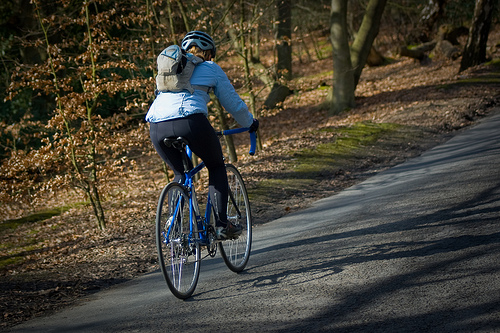

In [913]:
caption_random_test_image()

Prediction: ['a man wearing a red shirt and a black shirt is walking on a sidewalk .']
GT caption #1: A dog jumping upside down in front of a man .
GT caption #2: A man demonstrating his black and white dog performing a back flip .
GT caption #3: A man in a white t-shirt watching a dog do a back flip
GT caption #4: A man standing behind a small black and white dog doing a back flip .
GT caption #5: Dog jumps backwards , doing trick with man outdoors .


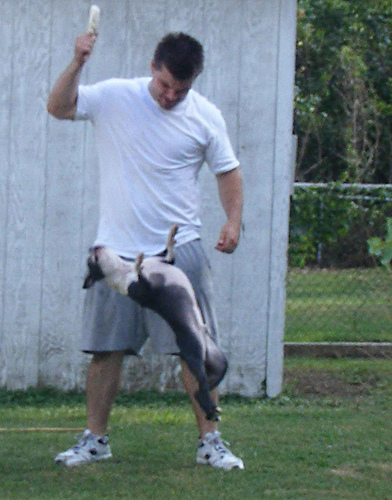

In [195]:
caption_random_test_image()

Что дальше? 

- Вы можете использовать механизм внимания, чтобы модель была лучше интерпреируема и была качественней.
Как это работает: https://distill.pub/2016/augmented-rnns/
Один из способов сделать это: https://arxiv.org/abs/1502.03044.
- Можно перейти на трансформеры